# Ian Hunt-Isaak   - HW 3


In [578]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import odeint

mpl.rc('figure',figsize=(10,10))
mpl.rc('font',size=20)

In [579]:
def x_deriv(Y, t, omega, alphas):
    return [Y[1],-Y[0]*omega**2+ np.polyval(alphas,Y[0])]

In [580]:

def lam_deriv(Z,t,y,alphas, omega,T):
    idx = np.argmin(T-t)
    f = np.poly1d(alphas)
    fp = np.polyder(f)
    return [Z[1],Z[0]*fp(y[idx])-Z[0]*omega**2]

In [581]:
def cost(data, omega, alphas):
    x_out = odeint(x_deriv,[2,-2],data[0],args=(omega,alphas))[:,0]
    return np.sum((data[1]-x_out)**2)

In [582]:
omega = np.sqrt(5)
alphas = np.array([.001,.001,.75,.75,0])
N_order = alphas.shape[0]-1

density = 3
N_intervals = data[0].shape[0]-1
T = np.linspace(data[0][0],data[0][-1],N_intervals*density)
n_iter = 500
learning_rate = 10**-2
costs = np.zeros(n_iter)
omega_hist = np.zeros(n_iter+1)
omega_hist[0] = omega
alpha_hist = np.zeros([n_iter+1,alphas.shape[0]])
alpha_hist[0] = alphas
cost_ref = cost(data, omega, alphas)

for n in range(n_iter):
    x_pred = odeint(x_deriv,[2,1],T,args=(omega,alphas))[:,0]
    omega_update = 0
    alpha_update = np.zeros_like(alphas)

    for interval in range(N_intervals):
        int_range_min = density*interval
        int_range_max = density*(interval+1) 
        dense_t = T[int_range_min:int_range_max]
        dense_x = x_pred[int_range_min:int_range_max]
        IC = [0,-2*(data[1][interval+1]-dense_x[-1])]
        t_prop = np.flip(dense_t,axis=0)
        lam_out = odeint(lam_deriv, IC, t_prop, args=(dense_x,alphas,omega,t_prop))
        omega_update += np.trapz(y=np.flip(lam_out[:,0],axis=0)*dense_x**0,x=dense_t)
        for i in range(alpha_update.shape[0]):
            alpha_update[i] += -np.trapz(y=np.flip(lam_out[:,0],axis=0)*dense_x**(N_order-i),x=dense_t)
    omega_update /= N_intervals
    alpha_update /= N_intervals
    omega -= omega_update*learning_rate
    alphas -= alpha_update*learning_rate
    omega_hist[n+1] = omega
    alpha_hist[n+1] = alphas

    costs[n] = cost(data, omega, alphas)
    if costs[n] < cost_ref*.1:
        learning_rate /= 5
        cost_ref = costs[n]

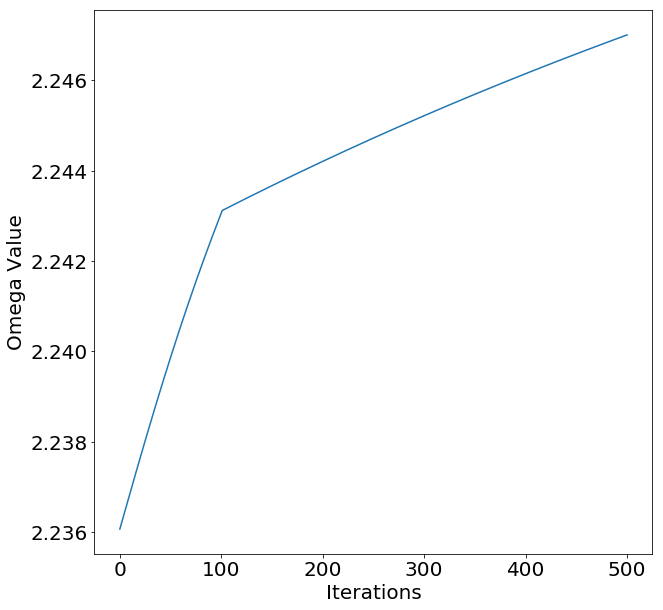

In [586]:
plt.plot(omega_hist)
plt.ylabel("Omega Value")
plt.xlabel('Iterations')
plt.show()

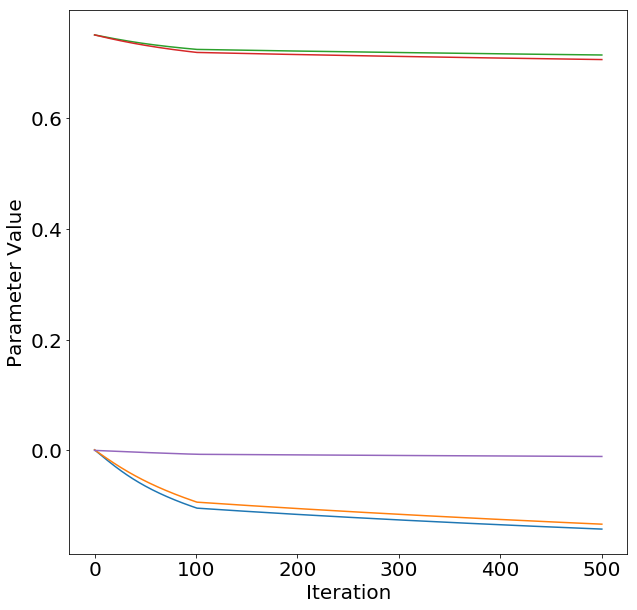

In [587]:

plt.plot(alpha_hist)
plt.ylabel('Parameter Value')
plt.xlabel('Iteration')
plt.show()

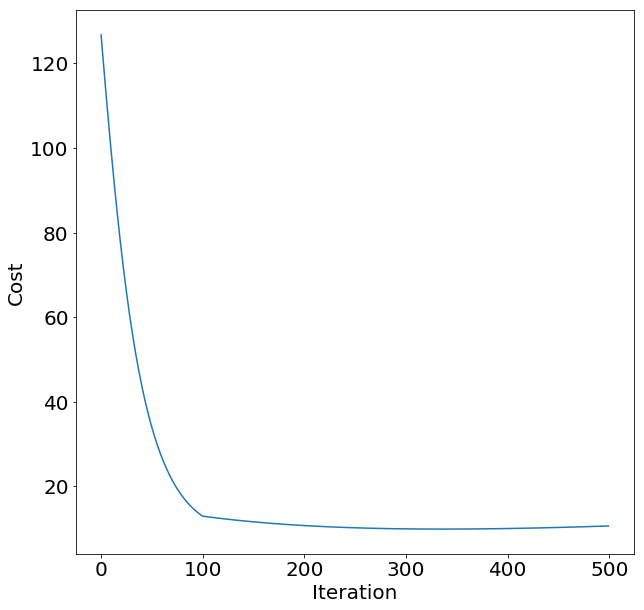

In [588]:
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iteration')
plt.show()

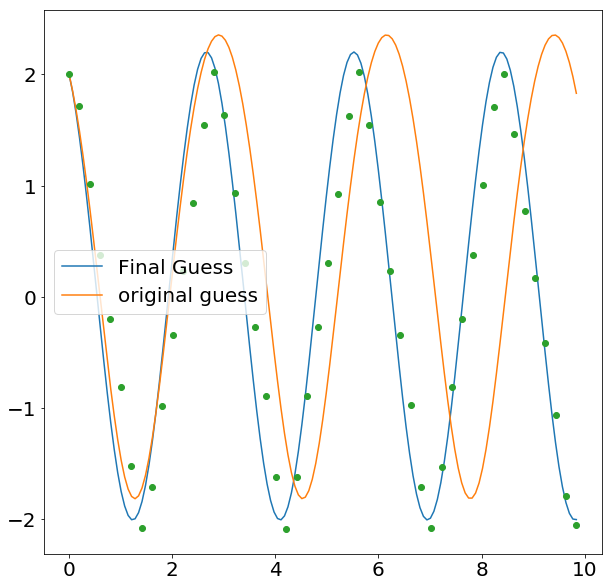

In [589]:
x_pred = odeint(x_deriv,[2,-2],T,args=(omega_hist[-1],alpha_hist[-1]))[:,0]
plt.plot(T,x_pred,label='Final Guess')
x_pred = odeint(x_deriv,[2,-2],T,args=(omega_hist[0],alpha_hist[0]))[:,0]
plt.plot(T,x_pred,label='original guess')
plt.plot(data[0],data[1],'o')
plt.legend()
plt.show()

### Works pretty well!

# Lorenz Equations


### Derived adjoints 

I'm interpreting this as given data and the functional form of the lorenz equations find the parameters. The adjoint method still has value here over the normal way we might do fitting because there is still the issue of propogating the differential equation.


(John Russell helped me through this, then we compared our final equations against each other's)

$\dot{\lambda_1}(t) - \sigma\lambda_1 + \lambda_2(\rho-z)+\lambda_3 y = 0$  
$\dot{\lambda_2}(t) + \sigma\lambda_1 - \lambda_2+\lambda_3 x = 0$  
$\dot{\lambda_3}(t) - x\lambda_2 - \beta\lambda_3 = 0$  


With intial condtions on the interval [$t_i$,$t_{i+1}$] being:  
$\lambda_1(t_{i+1}) = 2(x_{data} - x_{pred}(t_{i+1}))$  
$\lambda_2(t_{i+1}) = 2(y_{data} - y_{pred}(t_{i+1}))$  
$\lambda_3(t_{i+1}) = 2(z_{data} - z_{pred}(t_{i+1}))$  


And the gradients will be:  
$\frac{\partial C}{\partial \sigma} = - \int \lambda_1(t)(y(t)-x(t))dt$  
$\frac{\partial C}{\partial \rho} = - \int \lambda_2(t)x(t)dt$  
$\frac{\partial C}{\partial \beta} =  \int \lambda_3(t)z(t)dt$  


Scroll below for seeing what happens and an my explanation for why I don't think this worked well.





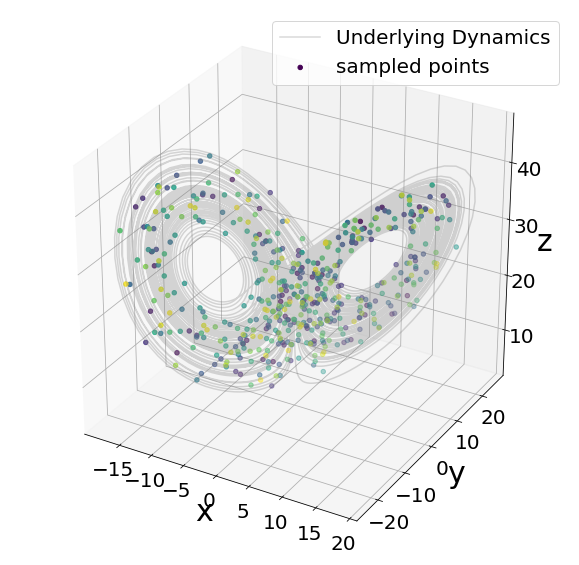

In [482]:
from mpl_toolkits.mplot3d import Axes3D
def lorenz_deriv(R, t, sigma, rho, beta):
    x = R[0]
    y = R[1]
    z = R[2]
    return [sigma*(y-x),x*(rho-z)-y,x*y-beta*z]

sigma = 10.
rho = 28.
beta = 8./3
lorenz_t = np.linspace(0,100,10000)
Lorenz_data_IC = [-5,10,15]
lorenz_data = odeint(lorenz_deriv,Lorenz_data_IC,lorenz_t,args=(sigma,rho,beta))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(lorenz_data[:,0], lorenz_data[:,1], lorenz_data[:,2],alpha = .3,color='gray',label='Underlying Dynamics')
lorenz_t = np.linspace(0,100,500)
lorenz_data = odeint(lorenz_deriv,[-5,10,15],lorenz_t,args=(sigma,rho,beta))

# print(out)
ax.scatter(lorenz_data[:,0], lorenz_data[:,1], lorenz_data[:,2],s=20,c=lorenz_t,label='sampled points')
ax.set_xlabel('x',fontsize=30)
ax.set_ylabel('y',fontsize=30)
ax.set_zlabel('z',fontsize=30)
plt.legend()
plt.show()

In [502]:
def lorenz_lambda_deriv(Lam, t, r, sigma, rho, beta,T):
    idx = np.argmin(T-t)
    x = r[:,0][idx]
    y = r[:,1][idx]
    z = r[:,2][idx]
    return [sigma*Lam[0]-Lam[1]*(rho-z)+Lam[2]*y,-sigma*Lam[0]+Lam[1]-Lam[2]*x, x*Lam[1]+beta*Lam[2]]
def lorenz_cost(t, points, sigma, rho, beta,data_IC):
    x_out = odeint(lorenz_deriv,data_IC,t,args=(sigma,rho,beta))
    return np.sum(np.linalg.norm(points-x_out,axis=1)**2)

In [503]:
lorenz_data.shape

(500, 3)

In [565]:
lorenz_t = np.linspace(0,100,500)
Lorenz_data_IC = [-5,10,15]
lorenz_data = odeint(lorenz_deriv,Lorenz_data_IC,lorenz_t,args=(sigma,rho,beta))


density = 5
N_intervals = lorenz_data.shape[0]-1
T = np.linspace(lorenz_t[0],lorenz_t[-1],N_intervals*density)
n_iter = 500
learning_rate = 10**-2.5


sigma = 10. - 3
rho = 28. + 2
beta = 8./3 +.456

costs = np.zeros(n_iter)
sigma_hist = np.zeros(n_iter+1)
rho_hist = np.zeros(n_iter+1)
beta_hist = np.zeros(n_iter+1)
sigma_hist[0] = sigma
rho_hist[0] = rho
beta_hist[0] = beta
# cost_ref = cost(data, omega, alphas)

for n in range(n_iter):
    lorenz_pred = odeint(lorenz_deriv,Lorenz_data_IC,T,args=(sigma,rho, beta))
    sigma_update = 0
    rho_update = 0
    beta_update = 0

    for interval in range(N_intervals):
        int_range_min = density*interval
        int_range_max = density*(interval+1) 
        dense_t = T[int_range_min:int_range_max]
        dense_pred = lorenz_pred[int_range_min:int_range_max]
        IC = lorenz_data[interval+1] - dense_pred[-1]
        t_prop = np.flip(dense_t,axis=0)
        lam_out = odeint(lorenz_lambda_deriv, IC, t_prop, args=(dense_pred,sigma, rho, beta,t_prop))
        sigma_update -= np.trapz(y=np.flip(lam_out[:,0],axis=0)*(dense_pred[:,1]-dense_pred[:,0]),x=dense_t)
        rho_update -= np.trapz(y=np.flip(lam_out[:,1],axis=0)*dense_pred[:,0],x=dense_t)
        beta_update = np.trapz(y=np.flip(lam_out[:,2],axis=0)*dense_pred[:,2],x=dense_t)
    sigma_update /= N_intervals
    rho_update /= N_intervals
    beta_update /= N_intervals
    

    sigma -= sigma_update*learning_rate
    rho -= rho_update*learning_rate
    beta -= beta_update*learning_rate
  
    sigma_hist[n+1] = sigma
    rho_hist[n+1] = rho
    beta_hist[n+1] = beta

    costs[n] = lorenz_cost(lorenz_t, lorenz_data, sigma, rho, beta,Lorenz_data_IC)
#     if costs[n] < cost_ref*.1:
#         learning_rate /= 5
#         cost_ref = costs[n]

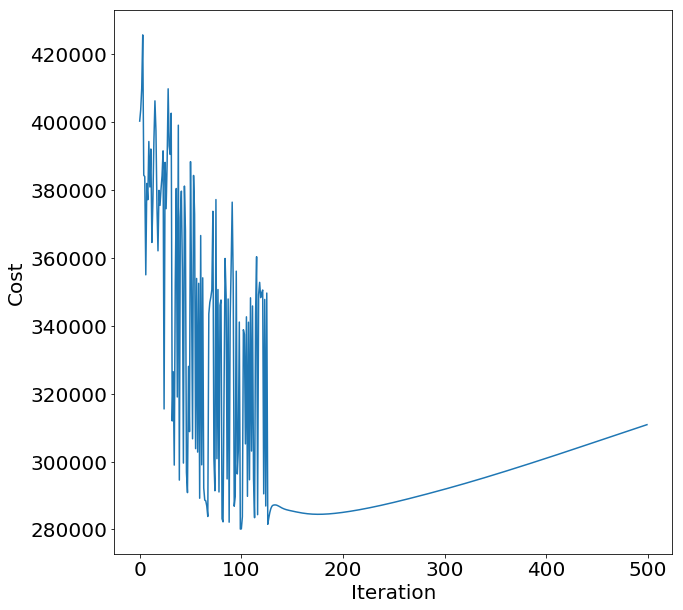

In [573]:
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iteration')
plt.show()

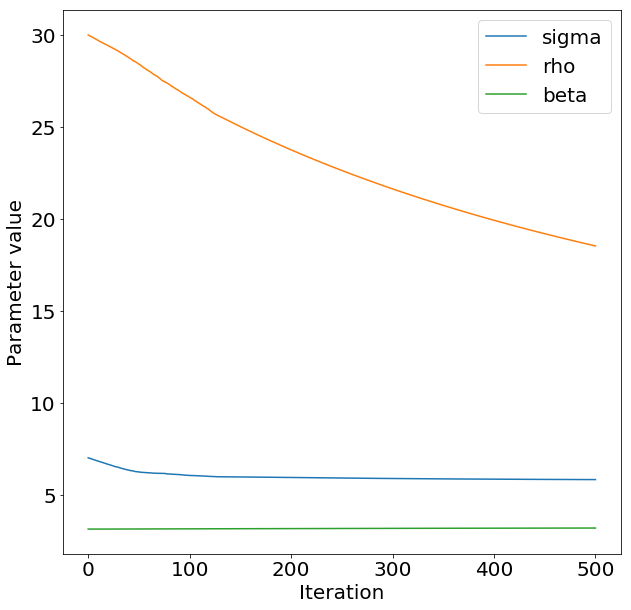

In [574]:
plt.plot(sigma_hist,label='sigma')
plt.plot(rho_hist,label='rho')
plt.plot(beta_hist,label='beta')
plt.legend()
plt.ylabel('Parameter value')
plt.xlabel('Iteration')
plt.show()

### Here I plot several projections of the predictions vs the training data. At the end I explain my thoughts.

6.04055597036
26.6489254975
3.13640079548


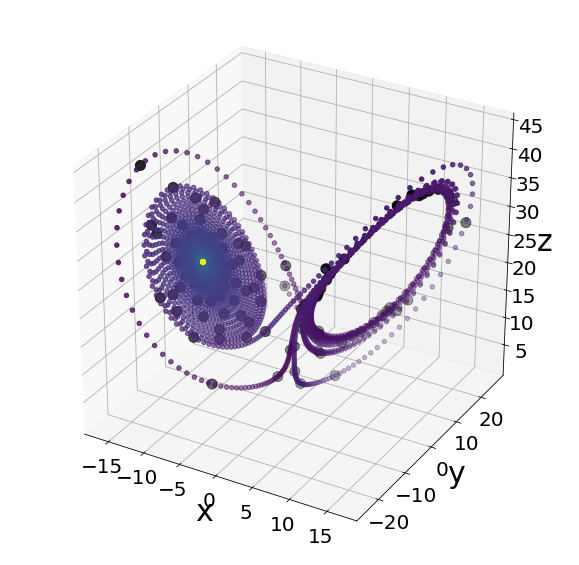

In [568]:
idx = np.argmin(costs)
sigma = sigma_hist[idx]
rho = rho_hist[idx]
beta = beta_hist[idx]

print(sigma)
print(rho)
print(beta)

lorenz_pred_t = np.linspace(0,100,10000)
Lorenz_data_IC = [-5,10,15]
lorenz_pred = odeint(lorenz_deriv,Lorenz_data_IC,lorenz_pred_t,args=(sigma,rho,beta))

lorenz_t = np.linspace(0,100,500)
Lorenz_data_IC = [-5,10,15]
lorenz_data = odeint(lorenz_deriv,Lorenz_data_IC,lorenz_t,args=(sigma,rho,beta))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# print(out)
ax.scatter(lorenz_data[:,0], lorenz_data[:,1], lorenz_data[:,2],s=100,c='k',zorder=0)
ax.scatter(lorenz_pred[:,0], lorenz_pred[:,1], lorenz_pred[:,2],s=20,c=lorenz_pred_t)
ax.set_xlabel('x',fontsize=30)
ax.set_ylabel('y',fontsize=30)
ax.set_zlabel('z',fontsize=30)
plt.legend()
plt.show()

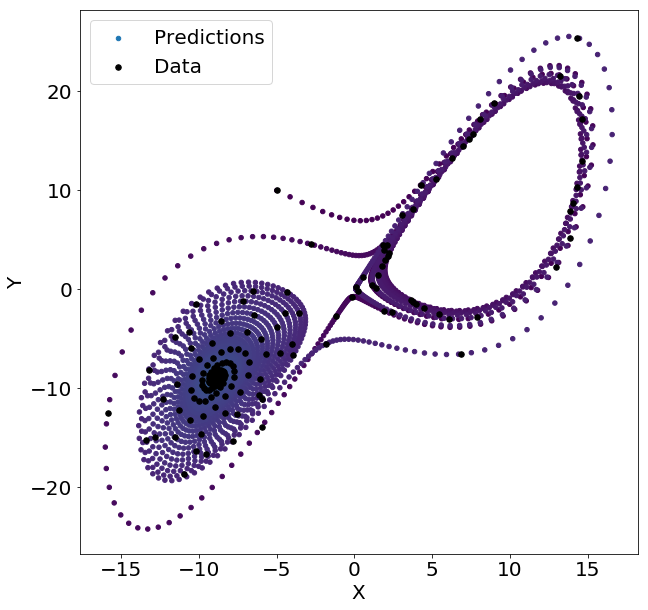

In [569]:
plt.scatter(lorenz_pred[:,0], lorenz_pred[:,1],s=20,c=lorenz_pred_t,label='Predictions')
plt.scatter(lorenz_data[:,0], lorenz_data[:,1],s=30,c='k',zorder=100,label='Data')
plt.ylabel('Y')
plt.xlabel('X')
plt.legend()
plt.show()

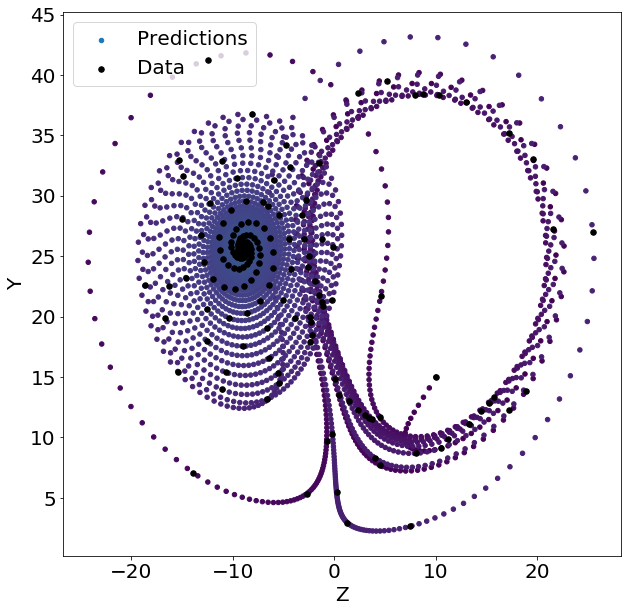

In [570]:
plt.scatter(lorenz_pred[:,1], lorenz_pred[:,2],s=20,c=lorenz_pred_t,label='Predictions')
plt.scatter(lorenz_data[:,1], lorenz_data[:,2],s=30,c='k',zorder=100,label='Data')
plt.ylabel('Y')
plt.xlabel('Z')
plt.legend()
plt.show()

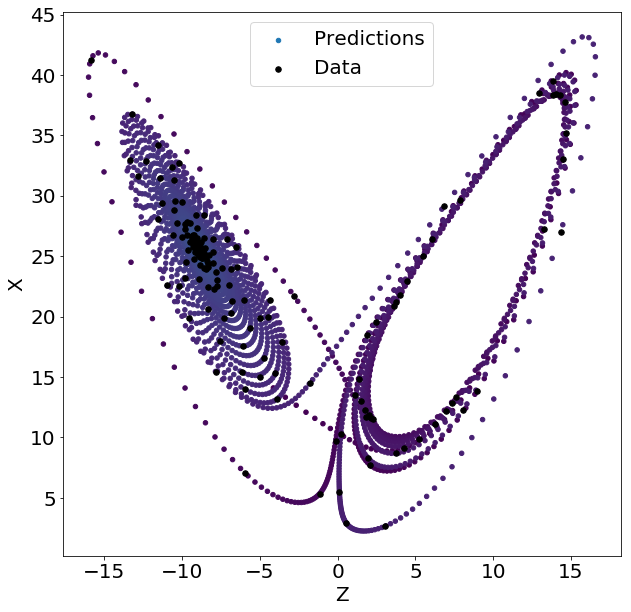

In [571]:
plt.scatter(lorenz_pred[:,0], lorenz_pred[:,2],s=20,c=lorenz_pred_t,label='Predictions')
plt.scatter(lorenz_data[:,0], lorenz_data[:,2],s=30,c='k',zorder=100,label='Data')
plt.ylabel('X')
plt.xlabel('Z')
plt.legend()
plt.show()

## Ok so I don't think this worked well.
My parameters started out in a chaotic region due to my intial guesses , this is region where my cost function is very choppy. Then it finds its way into a nonchaotic region and stays there (smooth cost function). I think that the chaotic nature of the lorenz equations makes your gradients too choppy to be effective at finding the local minimum and this is why this doesn't work.